In [1]:
# handle datasets
import pandas as pd
import numpy as np
# plotting
import matplotlib.pyplot as plt
# save the pipeline
import joblib
# from Scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)
from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)
from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import preprocessors as pp

# pandas display options
pd.pandas.set_option('display.max_columns', None)

In [2]:
# categorical variables with NA in train set
CATEGORICAL_VARS_WITH_NA_FREQUENT = ['BsmtQual', 'BsmtExposure',
                                     'BsmtFinType1', 'GarageFinish']


CATEGORICAL_VARS_WITH_NA_MISSING = ['FireplaceQu']


# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = ['LotFrontage']


TEMPORAL_VARS = ['YearRemodAdd']
REF_VAR = "YrSold"

# this variable is to calculate the temporal variable,
# can be dropped afterwards
DROP_FEATURES = ["YrSold"]

# variables to log transform
NUMERICALS_LOG_VARS = ["LotFrontage", "1stFlrSF", "GrLivArea"]


# variables to binarize
BINARIZE_VARS = ['ScreenPorch']

# variables to map
QUAL_VARS = ['ExterQual', 'BsmtQual',
             'HeatingQC', 'KitchenQual', 'FireplaceQu']

EXPOSURE_VARS = ['BsmtExposure']

FINISH_VARS = ['BsmtFinType1']

GARAGE_VARS = ['GarageFinish']

FENCE_VARS = ['Fence']


# categorical variables to encode
CATEGORICAL_VARS = ['MSSubClass',  'MSZoning',  'LotShape',  'LandContour',
                    'LotConfig', 'Neighborhood', 'RoofStyle', 'Exterior1st',
                    'Foundation', 'CentralAir', 'Functional', 'PavedDrive',
                    'SaleCondition']


# variable mappings
QUAL_MAPPINGS = {'Po': 1, 'Fa': 2, 'TA': 3,
                 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

EXPOSURE_MAPPINGS = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

FINISH_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1,
                   'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

GARAGE_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}


# the selected variables
FEATURES = [
    'MSSubClass',
    'MSZoning',
    'LotFrontage',
    'LotShape',
    'LandContour',
    'LotConfig',
    'Neighborhood',
    'OverallQual',
    'OverallCond',
    'YearRemodAdd',
    'RoofStyle',
    'Exterior1st',
    'ExterQual',
    'Foundation',
    'BsmtQual',
    'BsmtExposure',
    'BsmtFinType1',
    'HeatingQC',
    'CentralAir',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'BsmtFullBath',
    'HalfBath',
    'KitchenQual',
    'TotRmsAbvGrd',
    'Functional',
    'Fireplaces',
    'FireplaceQu',
    'GarageFinish',
    'GarageCars',
    'GarageArea',
    'PavedDrive',
    'WoodDeckSF',
    'ScreenPorch',
    'SaleCondition',
    # this one is only to calculate temporal variable:
    "YrSold",
]


In [3]:
# load dataset
data = pd.read_csv('../datasets/train.csv')
print(data.shape)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

y_train = np.log(y_train)
y_test = np.log(y_test)

(1460, 81)
(1314, 79) (146, 79)
(1314,) (146,)


In [4]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

## End-to-end Pipeline

In [5]:
price_pipe = Pipeline([
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING
    )),
    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQUENT
    )),
    # add missing indicator
    ('missing_indicator', AddMissingIndicator(
        variables=NUMERICAL_VARS_WITH_NA
    )),
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA
    )),
    ('elapsed_time', pp.TemporalVariableTransformer(
        variables=TEMPORAL_VARS, reference_variable=REF_VAR
    )),
    ('drop_features', DropFeatures(
        features_to_drop=[REF_VAR]
    )),
    ('log', LogTransformer(
        variables=NUMERICALS_LOG_VARS
    )),
    #('yeojohnson', YeoJohnsonTransformer(
    #    variables=NUMERICALS_YEO_VARS
    #)),
    ('binarizer', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_VARS
    )),
    ('mapper_qual', pp.Mapper(
        variables=QUAL_VARS, mappings=QUAL_MAPPINGS
    )),
    ('mapper_exposure', pp.Mapper(
        variables=EXPOSURE_VARS, mappings=EXPOSURE_MAPPINGS
    )),
    ('mapper_finish', pp.Mapper(
        variables=FINISH_VARS, mappings=FINISH_MAPPINGS
    )),
    ('mapper_garage', pp.Mapper(
        variables=GARAGE_VARS, mappings=GARAGE_MAPPINGS
    )),
    #('mapper_fence', pp.Mapper(
    #    variables=FENCE_VARS, mappings=FENCE_MAPPINGS
    #)),
    # ==== CATEGORICAL ENCONDING ====
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=1, variables=CATEGORICAL_VARS
    )),
    ('categorical_encoder', OrdinalEncoder(
        encoding_method='ordered', variables=CATEGORICAL_VARS
    )),
    ('scaler', MinMaxScaler()),
    ('Lasso', Lasso(alpha=0.001, random_state=0)),
])

In [6]:
# Converta as variáveis categóricas para o tipo 'category'
for col in CATEGORICAL_VARS:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

price_pipe.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['FireplaceQu'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtQual', 'BsmtExposure',
                                               'BsmtFinType1',
                                               'GarageFinish'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['LotFrontage'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method=...
                                             'Foundation', 'CentralAir',
                                             'Functional', 'PavedDrive',
                                             'SaleCondition'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['MSSubClass', 'MSZoning', 'LotShape',
                                           'LandContour',

In [8]:
# Evaluate de model
# -----------------

# make predictions for train set
pred = price_pipe.predict(X_train)
# determine performance
print('train mse: {}'.format(
    int(mean_squared_error(np.exp(y_train), np.exp(pred)))
))
print('train_rmse: {}'.format(
    int(mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))
))
print('train_r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))
))
print()

# make predictions for test set
pred = price_pipe.predict(X_test)
# determine performance
print('train mse: {}'.format(
    int(mean_squared_error(np.exp(y_test), np.exp(pred)))
))
print('train_rmse: {}'.format(
    int(mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))
))
print('train_r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))
))
print()

print('Average house price: {}'.format(int(
    np.exp(y_train).mean()
)))

train mse: 781396630
train_rmse: 27953
train_r2: 0.8748530315439078

train mse: 1060769014
train_rmse: 32569
train_r2: 0.8456415571208442

Average house price: 181040


Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

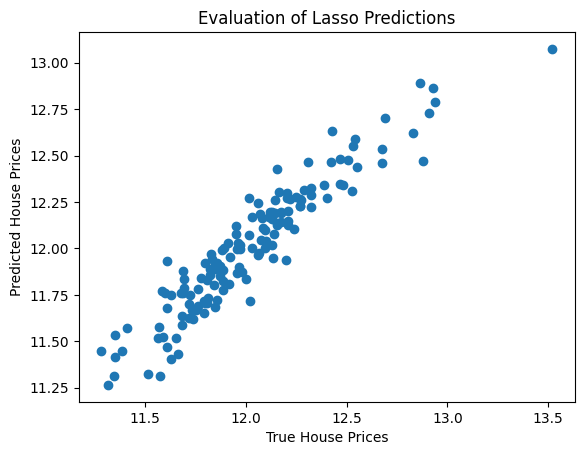

In [9]:
plt.scatter(y_test, price_pipe.predict(X_test))
plt.xlabel('True House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Evaluation of Lasso Predictions')

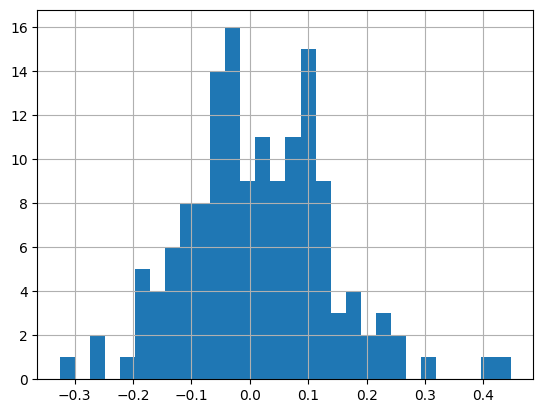

In [10]:
y_test.reset_index(drop=True, inplace=True)
preds = pd.Series(price_pipe.predict(X_test))

errors = y_test - preds
errors.hist(bins=30)
plt.show()

In [11]:
# save the whole pipeline
joblib.dump(price_pipe, 'price_pipe.joblib')

['price_pipe.joblib']

In [17]:
# Score new data
# --------------

data = pd.read_csv('../datasets/test.csv')
print(data.shape)

data.drop('Id', axis=1, inplace=True)
data['MSSubClass'] = data['MSSubClass'].astype('O')
data = data[FEATURES]
print(data.shape)

(1459, 80)
(1459, 37)


In [18]:
# the pipeline won't be able to score observations with NANs in features
# that don't have NANs in the train set

new_vars_with_na = [
    var for var in FEATURES if var not in CATEGORICAL_VARS_WITH_NA_MISSING + \
    CATEGORICAL_VARS_WITH_NA_FREQUENT + NUMERICAL_VARS_WITH_NA \
        and data[var].isnull().sum() > 0 
]

print(new_vars_with_na)

['MSZoning', 'Exterior1st', 'BsmtFullBath', 'KitchenQual', 'Functional', 'GarageCars', 'GarageArea']


In [19]:
data[new_vars_with_na].isnull().mean()

MSZoning        0.002742
Exterior1st     0.000685
BsmtFullBath    0.001371
KitchenQual     0.000685
Functional      0.001371
GarageCars      0.000685
GarageArea      0.000685
dtype: float64

In [20]:
data.dropna(subset=new_vars_with_na, inplace=True)
print(data.shape)

(1449, 37)


C:\Users\chafu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\feature_engine\encoding\rare_label.py:264: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Rare' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[~X[feature].isin(self.encoder_dict_[feature] + with_nan), feature] = (


<Axes: >

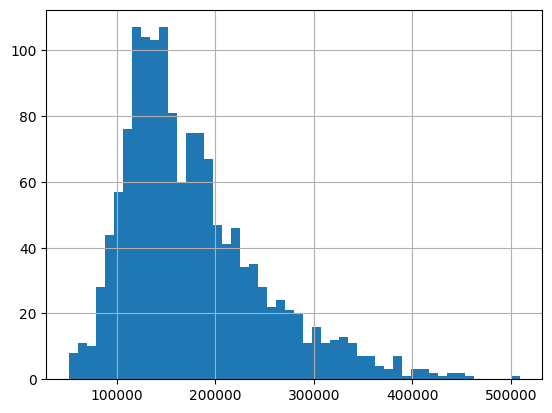

In [21]:
new_preds = price_pipe.predict(data)

pd.Series(np.exp(new_preds)).hist(bins=50)